In [52]:
%load_ext autoreload
%autoreload 2
import os
gpu = 3

# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_LAUNCH_BLOCKING'] = str(1) # get more error messages
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' #stop jax from preallocating 75% of the gpu

import jax.numpy as jnp
intial_jax = jnp.zeros((1,1))
from jax import lax
from jax import random
from flax import linen as nn # needed to install
import jax

import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import os
from PIL import Image
from scipy import optimize
import scipy.signal as sp
import sdc_config5 as sdc
import wandb  # needed to install
from ipywidgets import IntProgress # needed to install
from IPython.display import display
import sys
import time
import optax

# define a loss function
def loss_func(xk, meas, m, hfftpad, thr, xytv, lamtv):
    # calculate the forward model
    sim_meas = sdc.jax_forward_model(xk, m, hfftpad)
    dlam, dy, dx = jnp.gradient(xk, axis=(0, 1,2))
    ddlam = jnp.gradient(dlam, axis=0)
    # calculate the data loss
    data_loss = jnp.linalg.norm((sim_meas - meas).ravel(),2)**2
    # data_loss = jnp.sum((sim_meas - meas)**2)
    # calculate the xy total variation loss
    tv_loss = jnp.linalg.norm(dx.ravel(),1) + jnp.linalg.norm(dy.ravel(),1)
    # # calculate the sparsity loss
    sparsity_loss = jnp.linalg.norm(xk.ravel(),1)
    # # calculate the lambda total variation loss
    lamtv_loss = jnp.linalg.norm(ddlam.ravel(),2)**2
    # calculate the total loss
    # print(data_loss, tv_loss, lamtv_loss, sparsity_loss)
    loss = data_loss + xytv*tv_loss + lamtv*lamtv_loss + thr*sparsity_loss
    return loss

def color_visualize(image, wavelengths, title='', figsize=(10,10)):
    # Create false color filter
    HSI_data = jnp.transpose(image, (1, 2, 0))
    HSI_data = jnp.reshape(HSI_data, [-1, image.shape[0]])
    false_color_image = sdc.HSI2RGB_jax(wavelengths, HSI_data , image.shape[1], image.shape[2], 65, False)
    
    plt.figure(figsize=figsize)
    plt.imshow(false_color_image**.6)
    if title!='':
        plt.title(title)
    plt.axis('off')
    plt.show()

def wandb_log_meas(wandb_log, meas):
    # plot the lenslet positions
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the measurement
    ax.imshow(meas, cmap='gray', vmin=0, vmax=1)
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['experimental_measurement'] = fig
    # close the figure
    plt.close()
    return wandb_log

def wandb_log_sim_meas(wandb_log, meas):
    # make the graph
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the measurement
    ax.imshow(meas, cmap='gray', vmin=0, vmax=1)
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['simulated_measurement'] = fig
    # close the figure
    plt.close()
    return wandb_log

def wandb_log_false_color_recon(wandb_log, recon, wavelengths):
    # Create false color filter
    HSI_data = jnp.transpose(recon, (1, 2, 0))
    HSI_data = jnp.reshape(HSI_data, [-1, recon.shape[0]])
    false_color_image = sdc.HSI2RGB_jax(wavelengths, HSI_data , recon.shape[1], recon.shape[2], 65, False)

    # make the graph
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the false color recon
    ax.imshow(false_color_image**.6)
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['false_color_recon'] = fig
    # close the figure
    plt.close()
    return wandb_log

def wandb_log_psf(wandb_log, psf):
    # make the graph
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the psf
    ax.imshow(psf, cmap='gray')
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['psf'] = fig
    # close the figure
    plt.close()
    return wandb_log

def wandb_log_ground_truth(wandb_log, gt):
    # make the graph
    fig, ax = plt.subplots(figsize=(10,10))
    # plot the psf
    ax.imshow(gt, cmap='gray')
    # turn off the axis
    ax.axis('off')
    # add plot to log dictionary
    wandb_log['ground_truth'] = fig
    # close the figure
    plt.close()
    return wandb_log


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


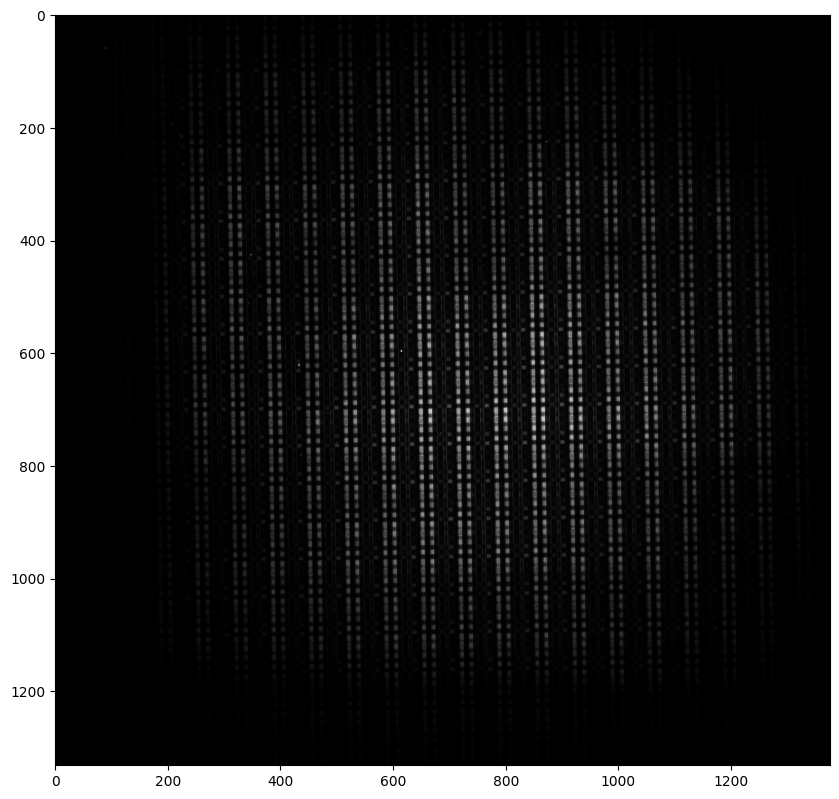

In [53]:
calibration_location = 'recon_materials_organized'
psf_name = 'psf_2024-01-30.pt'
calibration_wavelengths_file = 'connie_cal_waves.pt'
filter_cube_file = 'connie_normalized_filter_cube.pt'
datafolder = '/media/azuldata/neerja/2024-02-08_usaf/usaf_10x'
ground_truth_spectra_locs = ['/media/azuldata/neerja/2022-04-08/greenbeads_oldslide_emissionspectra.csv', 
                            '/media/azuldata/neerja/2022-04-08/redbeads_fresh_emissionspectra.csv']
bits = 16
crop_indices = [520,1852,1350,2726]
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 1
sample = datafolder.split('/')[-1]
kmax = 5000
step_size = 1e-1
thr = 6e-5
xytv =   1e-5
lamtv =  2e-5 #2e-6 
kprint = 100
dict_learn = False
bin_factor = 2
filter_subtract = True #subtract calibration filter min

run_name = sample + '_thr={}_xytv={}_lamtv={}_kmax={}_stepsize={}_downsample={}_bin_factor={}'.format(thr, xytv, lamtv, kmax, step_size, downsample_factor,bin_factor)

# load the measurement and display it to make sure your crop indices are correct

# Uncomment this line to load from a folder of measurements to average over
# sample_meas = torch.mean(sdc.tif_loader(os.path.join(datafolder,'measurements'))/2**bits,0)
# Uncomment this line to load from a single measurement 
sample_meas = sdc.importTiff(datafolder,'meas.tiff')/2**bits
try:
    background = sdc.importTiff(datafolder,'bg.tiff')/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
meas = sdc.cropci((sample_meas-background).clip(0,1),crop_indices)

sdc.bw_visualize(meas)

In [54]:
# Set up waits and biases run
wandb.init(
    # Set the project where this run will be logged
    project='HyperSpectralDiffuserScope', 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=run_name,
    # Track hyperparameters and run metadata
    config={"wvmin": wvmin,
            "wvmax": wvmax,
            "wvstep": wvstep,
            "kmax": kmax,
            "step_size": step_size,
            "thr": thr,
            "xytv": xytv,
            "lamtv": lamtv,
            "kprint": kprint,
            "dict_learn": dict_learn,
            "downsample_factor": downsample_factor,
            "bin_factor": bin_factor,
            "sample": sample,
            "gpu": gpu,
            "filter_sub": filter_subtract}
)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


data_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
data_loss,116.88648
loss,155.76933


In [55]:
device = 'cpu' # leave this as is. 

# Load wavelength calibration and downsample to spectral resolution of filter cube
wv = torch.load(os.path.join(calibration_location, calibration_wavelengths_file),map_location='cpu')
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

# Load and crop filter cube
normalized_filter_cube = torch.load(os.path.join(calibration_location,filter_cube_file),map_location='cpu')
filterstack = sdc.cropci(normalized_filter_cube, crop_indices)
msum = sdc.sumFilterArray(filterstack,wv,wvmin,wvmax,wvstep)
spectral_filter = msum/torch.amax(msum)
if filter_subtract == True:
    spectral_filter = spectral_filter - torch.amin(spectral_filter,0,keepdim=True)[0] # line added to deal with stripe artifact

# Load and crop PSF
sensor_psf = torch.load(os.path.join(calibration_location, psf_name),map_location='cpu')
ccrop = torchvision.transforms.CenterCrop(spectral_filter.shape[1:])
psf = ccrop(sensor_psf)
psf = psf/torch.sum(psf)
psf = psf.clip(0)

# Load measurement
# Uncomment this line to load from a folder of measurements to average over
# sample_meas = torch.mean(sdc.tif_loader(os.path.join(datafolder,'measurements'))/2**bits,0)
# Uncomment this line to load from a single measurement 
sample_meas = sdc.importTiff(datafolder,'meas.tiff')/2**bits
try:
    background = sdc.importTiff(datafolder,'bg.tiff')/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
meas = sdc.cropci((sample_meas-background).clip(0,1),crop_indices)

# Load ground truth image
try:
    gt = sdc.importTiff(datafolder,'gt.tiff')/2**bits
    gt = gt/torch.max(gt)
    gt = torchvision.transforms.functional.rotate(gt.unsqueeze(0),-90).squeeze()
except:
    print('No ground truth image found, continuing without ground truth')
    gt = torch.zeros(meas.shape)

# Load ground truth spectra
legend = []
spectra = []
for loc in ground_truth_spectra_locs:
    gt_wv,gt_int = sdc.loadspectrum(loc)
    gt_int = np.interp(wavelengths,gt_wv,gt_int)
    gt_int = gt_int/np.max(gt_int)
    gt_int = torch.tensor(gt_int).to(device)
    spectra.append(gt_int)
    legend.append(loc.split('/')[-1].split('.')[0].split('_')[0])



806


# Bin the data

In [56]:
import numpy as np

def crop_to_multiple(array, multiple):
    """
    Ensure the last two dimensions of the array are multiples of 4.
    If not, crop the array to make it so.
    
    Parameters:
    - array: A numpy array of at least 2 dimensions.
    
    Returns:
    - A numpy array cropped to ensure the last two dimensions are multiples of 4.
    """
    # Get the current shape of the array
    *leading_dims, height, width = array.shape
    
    # Calculate the new height and width to be multiples of 4
    new_height = height - (height % multiple)
    new_width = width - (width % multiple)
    
    # Crop the array to the new dimensions
    cropped_array = array[..., :new_height, :new_width]
    
    return cropped_array

# Example usage
# Assuming `your_array` is the numpy array you want to ensure has its last two dimensions as multiples of 4
# your_array = np.random.rand(10, 10)  # Example array, replace with your actual array

# Crop the array
# cropped_array = crop_to_multiple_of_four(your_array)

# print("Original shape:", your_array.shape)
# print("Cropped shape:", cropped_array.shape)


In [57]:
import torch
import torch.nn.functional as F

# Assuming `image` is your PyTorch tensor representing the image
# with shape [C, H, W] for a single image or [N, C, H, W] for a batch of images.
# C is the number of channels, H is the height, W is the width, and N is the batch size.

# Perform kxk binning
kernel_size = bin_factor  # Binning factor
stride = kernel_size  # Moving the kernel by kernel pixels for the next operation, effectively reducing the size by kernel
padding = 0  # No padding

psf = F.avg_pool2d(psf.unsqueeze(0).unsqueeze(0), kernel_size, stride=stride, padding=padding).squeeze().squeeze()
spectral_filter = F.avg_pool2d(spectral_filter.unsqueeze(0), kernel_size, stride=stride, padding=padding).squeeze()
meas = F.avg_pool2d(meas.unsqueeze(0).unsqueeze(0), kernel_size, stride=stride, padding=padding).squeeze().squeeze()
# binned_image is the output with the binned (downsampled) result

# crop things to follow factor of 4 in x and y cause it avoids some pad/crop issues later.
psf = crop_to_multiple(psf,4)
spectral_filter = crop_to_multiple(spectral_filter,4)
meas = crop_to_multiple(meas,4)


In [58]:
print(spectral_filter.shape)
print(psf.shape)
print(meas.shape)

torch.Size([60, 664, 688])
torch.Size([664, 688])
torch.Size([664, 688])


In [59]:

# Downsample and move everything to device (if needed)
# spectral_filter = spectral_filter[:,::downsample_factor,::downsample_factor].to(device)
# psf = psf[::downsample_factor,::downsample_factor].to(device)
# meas = meas[::downsample_factor,::downsample_factor].to(device)
 

gt = gt.to(device)

xk = jnp.zeros(spectral_filter.shape)
hpad = jnp.asarray(sdc.pad(psf))
hfftpad = jnp.fft.fft2(hpad)[None, ...]
m = jnp.asarray(spectral_filter)
meas = jnp.asarray(meas)

padding = ((0,0,0),(np.ceil(xk.shape[1]/2).astype(int),np.floor(xk.shape[1]/2).astype(int),0),(np.ceil(xk.shape[2]/2).astype(int),np.floor(xk.shape[2]/2).astype(int),0))
# calculate the adjoint
xk = sdc.jax_adjoint_model(meas, m, hfftpad, padding)
# xk = jnp.zeros_like(xk)+1

# define the optimizer
optimizer = optax.adam(learning_rate=step_size, b1=0.9, b2=0.999)

# Initialize optimizer state
opt_state = optimizer.init(xk)

# define a function to calculate the gradient and return the loss
loss_and_grad = jax.jit(jax.value_and_grad(loss_func, (0)))


In [60]:
print(xk.shape)
print(m.shape)
print(hfftpad.shape)
print(meas.shape)

(60, 664, 688)
(60, 664, 688)
(1, 1328, 1376)
(664, 688)


# Start the training loop

In [61]:

# run a training loop with a progress bar
for k in range(kmax):
    wandb_log = {}
    if k == 0: 
        wandb_log = wandb_log_meas(wandb_log, meas)
        wandb_log = wandb_log_psf(wandb_log, psf)
        wandb_log = wandb_log_ground_truth(wandb_log, gt)
    # calculate the loss and the gradient
    loss, grad = loss_and_grad(xk, meas, m, hfftpad, thr, xytv, lamtv)

    # log the mse of the measurement and simulated measurement
    wandb_log['data_loss'] = jnp.linalg.norm((sdc.jax_forward_model(xk, m, hfftpad) - meas).ravel(),2)**2

    # log the custom loss
    wandb_log['loss'] = loss

    # update the parameters
    updates, opt_state = optimizer.update(grad, opt_state)
    # replace nan values with 0
    updates = jnp.nan_to_num(updates)
    # break
    xk = optax.apply_updates(xk, updates)
    xk = jnp.clip(xk, 0, None)
    
    if k % kprint == 0 or k == kmax-1: # moved to after the update step - Neerja Feb 5th, 2024
        wandb_log = wandb_log_sim_meas(wandb_log, sdc.jax_forward_model(xk, m, hfftpad))
        wandb_log = wandb_log_false_color_recon(wandb_log, xk/jnp.max(xk)*jnp.sum(xk,0)[None,...], wavelengths)
        # save xk
        torch.save(xk, os.path.join('Results', run_name+'.pt'))

    wandb.log(wandb_log)

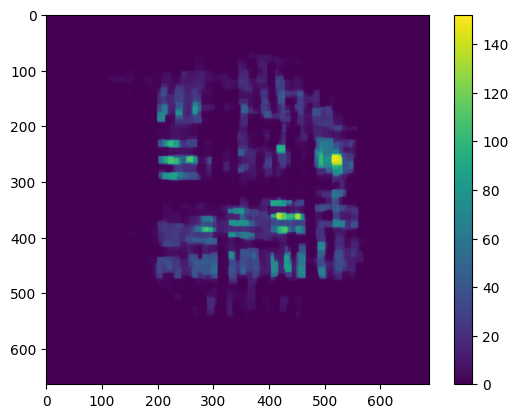

In [62]:
plt.imshow(np.sum(xk, axis = 0), )
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


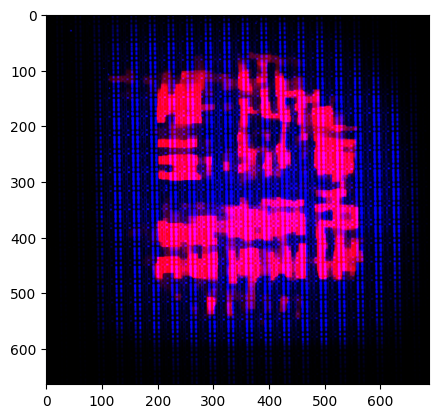

: 

In [63]:
xsum = np.sum(xk, axis = 0)
xsum = xsum/np.amax(xsum)
x0 = jnp.zeros_like(xsum)
rgstack = np.stack([xsum*10, x0,meas/np.amax(meas)*10], axis = 2)
rgstack.shape
plt.imshow(rgstack)